# Paso 1 : 
Abrir el archivo de datos y leer la información general

In [65]:
#importar librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from math import sqrt
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportions_ztest


## Data Cleaning / Limpieza de Datos

In [35]:
#cargar datos
df = pd.read_csv('dataset/logs_exp_us.csv', sep = '\t')  #Separamos el archivo para que lo lea correctamente
print(df.head())
print('\n')

#modificar columnas
columns_new = {'EventName' : 'event_name',
               'DeviceIDHash' : 'device_id_hash',
               'EventTimestamp' : 'event_timestamp',
               'ExpId': 'exp_id',}
df = df.rename(columns = columns_new) #Usamos la función rename para renombrar las columnas

#Comprobar tipos de datos y valores ausentes
print(df.info())
print(df.isna().sum()) #No hay valores nulos
print('\n')

#Convertir la columna event_timestamp a formato datetime
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='s', utc=True) #En la columna event_timestamp, los datos estaban en formato Unix(numero de segundos desde 1970), por lo que usamos unit='s' para convertirlos a datetime
print(df.info())

df['event_date'] = df['event_timestamp'].dt.date #Creamos una nueva columna llamada event_date que contiene solo la fecha (sin la hora) de event_timestamp
display(df.head()) 

                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64


<class 'pandas.core.frame.DataFr

,event_name,device_id_hash,event_timestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36+00:00,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42+00:00,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47+00:00,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47+00:00,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42+00:00,248,2019-07-25


 ### ¿Cuántos eventos hay en los registros?

In [36]:
print(f'Filas originales: {len(df)} ')
#Considerando que cada entrada de registro es una acción de usuario o un evento, segun en la descripción del dataset. Es necesario contar las filas para saber el número total de eventos en los registros. Sin embargo, hay que tomar en cuenta si tenemos filas duplicadas.

duplicated = df[df.duplicated(subset=['event_name', 'device_id_hash', 'event_timestamp'], keep=False)]
print(f'Filas duplicadas detalladas:\n {duplicated.head()} \n')


#Al observar el data set podemos concluir que las filas duplicadas son registros exactos de eventos que ocurrieron en el mismo momento para el mismo usuario. Por lo tanto, debemos eliminarlas o excluirlas para evitar un sesgo en el conteo de eventos y en las proximas pruebas del testing A/A/B
df_clean = df.drop_duplicates(
    subset=['event_name', 'device_id_hash', 'event_timestamp'],
    keep='first'
)
print(f"Filas después de limpiar: {len(df_clean)}")
print(f"Duplicados eliminados: {len(df) - len(df_clean)}")

#Número total de eventos en los registros
total_events = len(df_clean)    
print(f'Número total de eventos en los registros: {total_events}')





Filas originales: 244126 
Filas duplicadas detalladas:
             event_name       device_id_hash           event_timestamp  exp_id  \
452   MainScreenAppear  5613408041324010552 2019-07-30 08:19:44+00:00     248   
453   MainScreenAppear  5613408041324010552 2019-07-30 08:19:44+00:00     248   
2348  CartScreenAppear  1694940645335807244 2019-07-31 21:51:39+00:00     248   
2350  CartScreenAppear  1694940645335807244 2019-07-31 21:51:39+00:00     248   
3572  MainScreenAppear   434103746454591587 2019-08-01 02:59:37+00:00     248   

      event_date  
452   2019-07-30  
453   2019-07-30  
2348  2019-07-31  
2350  2019-07-31  
3572  2019-08-01   

Filas después de limpiar: 243713
Duplicados eliminados: 413
Número total de eventos en los registros: 243713


### ¿Cuántos usuarios hay en los registros?

In [37]:
user_per_registers = df_clean['device_id_hash'].nunique()
print(f'Número total de usuarios en los registros: {user_per_registers}')

Número total de usuarios en los registros: 7551


### ¿Cuál es el promedio de eventos por usuario?

In [38]:
average_events_per_user = total_events / user_per_registers 
print(f'Promedio de eventos por usuario: {average_events_per_user:.2f}')

Promedio de eventos por usuario: 32.28


### ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?

===Datos incompletos===
Fecha mínima: 2019-07-25 04:43:36+00:00
Fecha máxima: 2019-08-07 21:15:17+00:00
Período total: 13 días


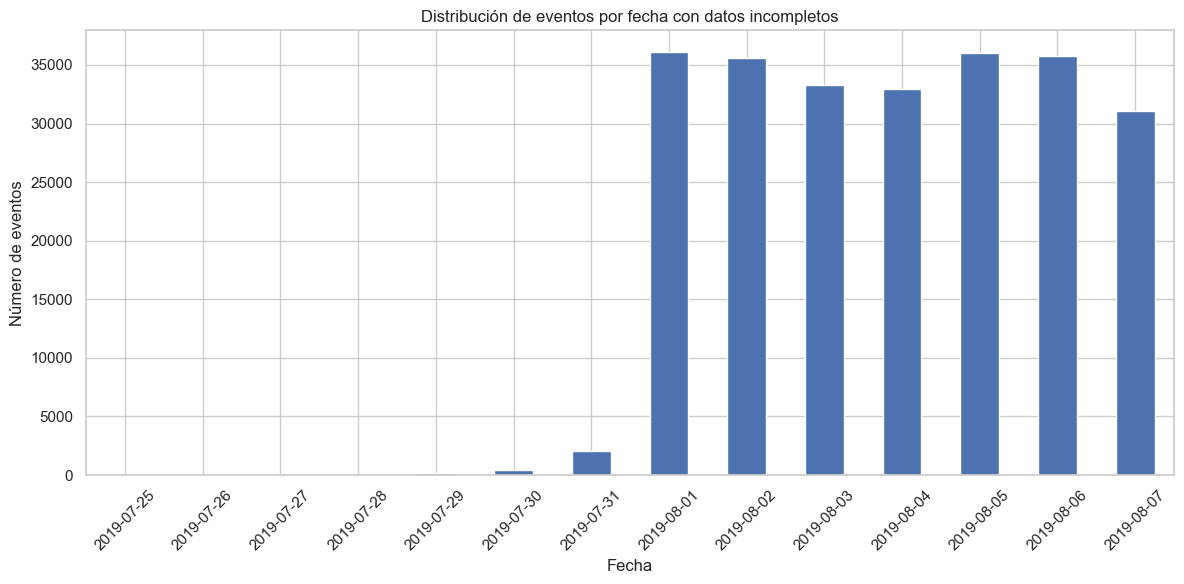

Período objetivo detectado automáticamente: 2019-08-01 a 2019-08-07


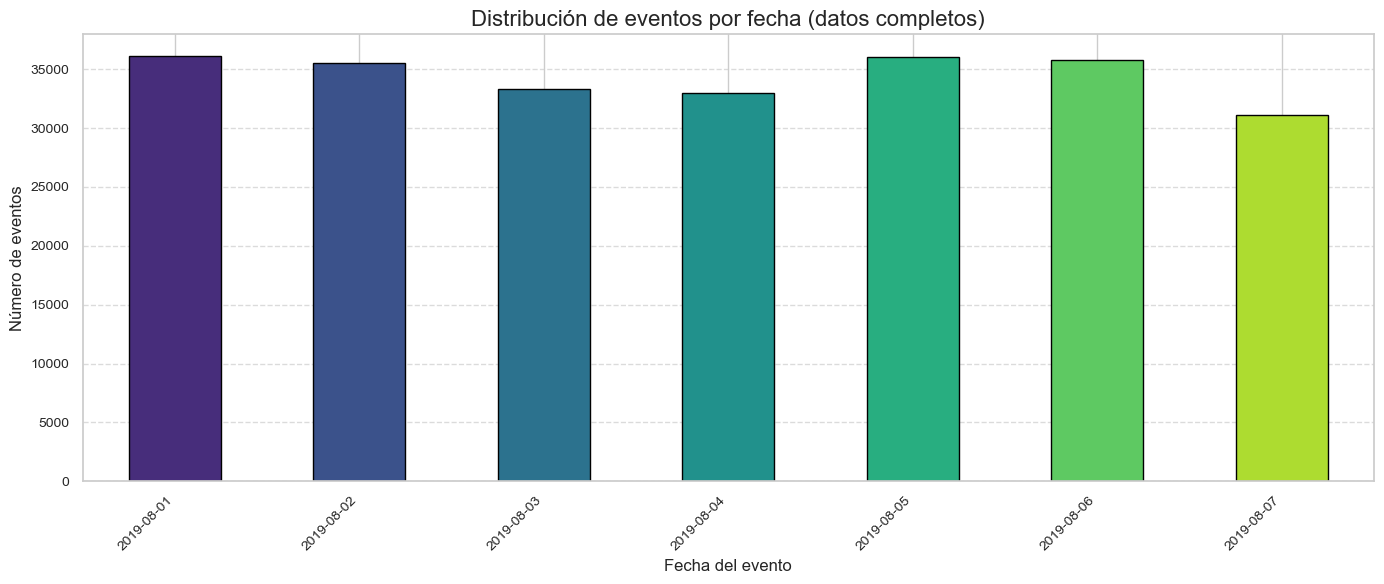

In [39]:
# Calcular fechas mínima y máxima
date_min = df_clean['event_timestamp'].min()
date_max = df_clean['event_timestamp'].max()

print(f'===Datos incompletos===')
print(f"Fecha mínima: {date_min}")
print(f"Fecha máxima: {date_max}")
print(f"Período total: {(date_max - date_min).days} días")

# Histograma por fecha
plt.figure(figsize=(12, 6))
df_clean['event_date'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de eventos por fecha con datos incompletos')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ===  LÓGICA PARA DEFINIR PERÍODO COMPLETO ===
# Agrupar por fecha y contar eventos
daily = df_clean.groupby('event_date').size().sort_index()

# Umbral del 95% del máximo
thr = 0.95 * daily.max()

# Detectar días que cumplen el umbral
consec = (daily >= thr).astype(int)

# Primer día que cumple la condición
start = consec[consec.eq(1)].index[0]

# Último día disponible
end = daily.index.max()

print(f'Período objetivo detectado automáticamente: {start} a {end}')

# Convertir a timestamp con zona horaria UTC
inicio = pd.Timestamp(start, tz='UTC')
fin = pd.Timestamp(end, tz='UTC') + pd.Timedelta(hours=23, minutes=59, seconds=59)

# Filtrar los datos para el período completo
df_filtrado = df_clean[(df_clean['event_timestamp'] >= inicio) & (df_clean['event_timestamp'] <= fin)]

# Histograma para el período filtrado
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
color = sns.color_palette("viridis", len(df_filtrado['event_date'].value_counts()))
df_filtrado['event_date'].value_counts().sort_index().plot(
    kind='bar',
    color=color,
    edgecolor='black'
)
plt.title('Distribución de eventos por fecha (datos completos)', fontsize=16)
plt.xlabel('Fecha del evento', fontsize=12)
plt.ylabel('Número de eventos', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [61]:
# Eventos excluidos por fecha
event_excluidos = df_clean[df_clean['event_date'] < inicio.date()]
print(f"Eventos excluidos: {len(event_excluidos)}")

# Porcentaje de eventos excluidos
porcentaje_eventos = (len(event_excluidos) / len(df_clean)) * 100
print(f"Porcentaje de eventos excluidos: {porcentaje_eventos:.2f}%\n")

# Usuarios con eventos antes del 01/08
users_before = set(df_clean[df_clean['event_date'] < inicio.date()]['device_id_hash'])

# Usuarios con eventos dentro del período completo
users_in_period = set(df_filtrado['device_id_hash'])

# Usuarios realmente perdidos (solo tenían eventos antes del corte)
users_perdidos = users_before - users_in_period

# Porcentaje de usuarios perdidos
porcentaje_usuarios_perdidos = 100 * len(users_perdidos) / df_clean['device_id_hash'].nunique()

print(f"Usuarios realmente perdidos: {len(users_perdidos)}")
print(f"Porcentaje de usuarios realmente perdidos: {porcentaje_usuarios_perdidos:.2f}%")


Eventos excluidos: 2826
Porcentaje de eventos excluidos: 1.16%

Usuarios realmente perdidos: 17
Porcentaje de usuarios realmente perdidos: 0.23%


Asegúrate de tener usuarios de los tres grupos experimentales.

In [41]:
grupos_esperados = [246, 247, 248]
grupos_encontrados = df_filtrado['exp_id'].unique()

print("=== VERIFICACIÓN DE GRUPOS EXPERIMENTALES ===")
print(f"Grupos esperados: {grupos_esperados}")
print(f"Grupos encontrados: {sorted(grupos_encontrados)}")

# Verificar si tienes todos los grupos
if set(grupos_esperados) == set(grupos_encontrados):
    print("ÉXITO: Tienes usuarios de los 3 grupos experimentales")
else:
    print(" ERROR: Faltan grupos experimentales")
    grupos_faltantes = set(grupos_esperados) - set(grupos_encontrados)
    print(f"Grupos faltantes: {grupos_faltantes}")



=== VERIFICACIÓN DE GRUPOS EXPERIMENTALES ===
Grupos esperados: [246, 247, 248]
Grupos encontrados: [np.int64(246), np.int64(247), np.int64(248)]
ÉXITO: Tienes usuarios de los 3 grupos experimentales


# Parte 4:
Estudiar el embudo de eventos

Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

In [42]:
eventos = df_filtrado['event_name'].value_counts()
print(f'Número de eventos por tipo:\n{eventos}\n')

Número de eventos por tipo:
event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: count, dtype: int64



Encuentra la cantidad de usuarios que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios. Calcula la proporción de usuarios que realizaron la acción al menos una vez.

In [62]:
# Número de usuarios únicos por tipo de evento
user_per_event = df_filtrado.groupby('event_name')['device_id_hash'].nunique()
print(f'Número de usuarios únicos por tipo de evento:\n{user_per_event.sort_values(ascending=False)}\n')

# Total de usuarios únicos en el período completo
total_users = df_filtrado['device_id_hash'].nunique()

# Proporción de usuarios que realizaron cada evento al menos una vez
prop_por_evento = (user_per_event / total_users) * 100
print(f'Proporción de usuarios únicos por tipo de evento (% sobre total de usuarios):\n{prop_por_evento.sort_values(ascending=False)}\n')

Número de usuarios únicos por tipo de evento:
event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: device_id_hash, dtype: int64

Proporción de usuarios únicos por tipo de evento (% sobre total de usuarios):
event_name
MainScreenAppear           98.473586
OffersScreenAppear         60.963632
CartScreenAppear           49.561986
PaymentScreenSuccessful    46.973719
Tutorial                   11.149456
Name: device_id_hash, dtype: float64



¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo


El orden es el siguiente: 
1 MainScreenAppear: la pantalla principal.
2 OffersScreenAppear: explorar ofertas o productos disponibles.
3 CartScreenAppear: los usuarios agregan los productos al carrito. 
4 PaymentScreenSuccessful: completar la compra en la pantalla de pago.

Tutorial: no forma parte del flujo de compra por lo tanto no estaria en el orden de como ocurrieron las acciones
 


Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B.

In [63]:
# Filtrar solo los eventos relevantes del embudo
eventos_embudo = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
t = df_filtrado[df_filtrado['event_name'].isin(eventos_embudo)]

# Ordenar por usuario y timestamp
t = t.sort_values(['device_id_hash', 'event_timestamp'])

# Obtener el primer timestamp por usuario y evento
times = t.groupby(['device_id_hash', 'event_name'])['event_timestamp'].min().unstack()

# Calcular proporciones respetando el orden temporal
p_main_to_offers = (times['OffersScreenAppear'] > times['MainScreenAppear']).sum() / times['MainScreenAppear'].notna().sum()
p_offers_to_cart = (times['CartScreenAppear'] > times['OffersScreenAppear']).sum() / times['OffersScreenAppear'].notna().sum()
p_cart_to_payment = (times['PaymentScreenSuccessful'] > times['CartScreenAppear']).sum() / times['CartScreenAppear'].notna().sum()

# Mostrar resultados
print(f"Main → Offers: {p_main_to_offers:.2%}")
print(f"Offers → Cart: {p_offers_to_cart:.2%}")
print(f"Cart → Payment: {p_cart_to_payment:.2%}")

Main → Offers: 56.62%
Offers → Cart: 43.98%
Cart → Payment: 25.52%


¿En qué etapa pierdes más usuarios?

In [64]:
# Conteos absolutos por etapa
n_main = len(users_main)
n_main_off = len(users_main & users_offers)

n_offers = len(users_offers)
n_offers_cart = len(users_offers & users_cart)

n_cart = len(users_cart)
n_cart_payment = len(users_cart & users_payment)

# Porcentajes de conversión (ya calculados antes)
print(f"Main → Offers: {p_main_to_offers:.2%} ({n_main_off}/{n_main})")
print(f"Offers → Cart: {p_offers_to_cart:.2%} ({n_offers_cart}/{n_offers})")
print(f"Cart → Payment: {p_cart_to_payment:.2%} ({n_cart_payment}/{n_cart})")

# Porcentajes de pérdida por etapa
loss_main_to_offers = 100 - p_main_to_offers * 100
loss_offers_to_cart = 100 - p_offers_to_cart * 100
loss_cart_to_payment = 100 - p_cart_to_payment * 100

print(f"\nPérdida de usuarios por etapa:")
print(f"Main → Offers: {loss_main_to_offers:.2f}%")
print(f"Offers → Cart: {loss_offers_to_cart:.2f}%")
print(f"Cart → Payment: {loss_cart_to_payment:.2f}%")

Main → Offers: 56.62% (4482/7419)
Offers → Cart: 43.98% (3679/4593)
Cart → Payment: 25.52% (3534/3734)

Pérdida de usuarios por etapa:
Main → Offers: 43.38%
Offers → Cart: 56.02%
Cart → Payment: 74.48%


¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

In [46]:
users_completed = users_main & users_offers & users_cart & users_payment
print(f'Número de usuarios que completaron todo el viaje hasta el pago: {len(users_completed)}')

total_usuarios_ = df_filtrado['device_id_hash'].nunique()
porcentaje_completos = (len(users_completed) / total_usuarios_) * 100
print(f"Porcentaje de usuarios que completan todo el viaje: {porcentaje_completos:.2f}%")

Número de usuarios que completaron todo el viaje hasta el pago: 3429
Porcentaje de usuarios que completan todo el viaje: 45.51%




# Parte 5: 
Estudiar los resultados del experimento




### ¿Cuántos usuarios hay en cada grupo?

In [47]:
group_per_users = df_filtrado.groupby('exp_id')['device_id_hash'].nunique()
print(f'Número de usuarios por grupo experimental:\n{group_per_users}\n')

Número de usuarios por grupo experimental:
exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64



### Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

est A/A = grupo 246(control) y grupo 247 (control). Entendemos que ambos grupos corresponde a una misma version.

Realizamos este test para verificar que los grupos esten correctamente dividos, las pruebas de medicion funcionen bien para poder confiar en el testA/B

Esperamos que no haya diferencia significativas para estos grupos para poder realizar la prueba A/B sin sesgos.

Primero debemos seleccionar la metrica a usar. Debido a que el objetivo de la empresa es generar ingresos y medir el impacto real de las nuevas fuentes se usara la tasa de conversion en el evento 'PaymentScreenSuccessful' de ambos grupos 

Tasa de conversión = (Usuarios que realizaron pago exitoso por grupo) / (Total de usuarios por grupo)

In [48]:
# Usuarios que realizaron pago exitoso por grupo
pago_246 = df_filtrado[(df_filtrado['exp_id'] == 246) & 
                       (df_filtrado['event_name'] == 'PaymentScreenSuccessful')]['device_id_hash'].nunique()

pago_247 = df_filtrado[(df_filtrado['exp_id'] == 247) & 
                       (df_filtrado['event_name'] == 'PaymentScreenSuccessful')]['device_id_hash'].nunique()

# Total de usuarios por grupo 
total_246 = 2484  #Esta informacion se obtuvo del conteo de usuarios por grupo
total_247 = 2513

# Tasas de conversión
tasa_246 = pago_246 / total_246
tasa_247 = pago_247 / total_247

print(f"Grupo 246 - Conversión a pago: {tasa_246:.4f} ({tasa_246:.2%})")
print(f"Grupo 247 - Conversión a pago: {tasa_247:.4f} ({tasa_247:.2%})")

Grupo 246 - Conversión a pago: 0.4831 (48.31%)
Grupo 247 - Conversión a pago: 0.4608 (46.08%)


Continuaremos a realizar una prueba estadística para determinar si hay diferencia significativa en ambos grupos. Por lo tanto, ya definido que nuestros datos son porcentaje  (tasa de conversion), se debe realizar la prueba Z ya que esta mide proporciones entre dos grupos independientes.

Antes de realizar la prueba Z debemos verificar los requisitos:
#1. El tamano de la prueba es grande: En nuestro caso si. Grupo246 :  2484 usuarios y grupo 247 :  2513 usuarios
#2.Conocer la desviacion estandar.

In [49]:
#Ahora procederemos a conocer la desviación estándar de dos proporciones

# Calcular la desviación estándar 
p_pooled = (pago_246 + pago_247) / (total_246 + total_247)
std_error = np.sqrt(p_pooled * (1 - p_pooled) * (1/total_246 + 1/total_247))
print(f"Desviación estándar: {std_error:.6f}")


Desviación estándar: 0.014124


In [50]:
# Teniendo ahora la desviacion estandar y las tasas de conversion, podemos proceder a realizar la Prueba Z para dos proporciones.
# Calcular el valor Z

z_score = (tasa_246 - tasa_247) / std_error
print(f"Estadístico z: {z_score:.4f}")

# 4. Calcular el p-value (test de dos colas)
p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
print(f"P-value: {p_value:.6f}")

# 5. Comparar con alpha = 0.05
alpha = 0.05
print(f"\nAlpha: {alpha}")
print(f"P-value < Alpha: {p_value < alpha}")

if p_value < alpha:
    print("RESULTADO: Hay diferencia estadísticamente significativa entre los grupos")
else:
    print("RESULTADO: No hay diferencia estadísticamente significativa entre los grupos")

Estadístico z: 1.5780
P-value: 0.114567

Alpha: 0.05
P-value < Alpha: False
RESULTADO: No hay diferencia estadísticamente significativa entre los grupos


Ahora podemos tener la seguridad en avanzar ya que no hay diferencias estadisticamente significativas en la tasa de conversion del evento pago exitoso

### Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?

In [51]:
print(f"Usuarios grupo 246: {total_246}")
print(f"Usuarios grupo 247: {total_247}")

# Para MainScreenAppear en grupos 246 y 247
evento_popular = 'MainScreenAppear'

# Filtrar por grupos de control
grupo_246 = df_filtrado[df_filtrado['exp_id'] == 246]
grupo_247 = df_filtrado[df_filtrado['exp_id'] == 247]

# Usuarios que realizaron MainScreenAppear por grupo
usuarios_evento_246 = grupo_246[grupo_246['event_name'] == evento_popular]['device_id_hash'].nunique()
usuarios_evento_247 = grupo_247[grupo_247['event_name'] == evento_popular]['device_id_hash'].nunique()

print(f"Usuarios que hicieron {evento_popular} en grupo 246: {usuarios_evento_246}")
print(f"Usuarios que hicieron {evento_popular} en grupo 247: {usuarios_evento_247}")

#Calcular proporciones
proporcion_246 = usuarios_evento_246 / total_246      
proporcion_247 = usuarios_evento_247 / total_247    

print(f"Proporción en grupo 246: {proporcion_246:.2%}")
print(f"Proporción en grupo 247: {proporcion_247:.2%}")

Usuarios grupo 246: 2484
Usuarios grupo 247: 2513
Usuarios que hicieron MainScreenAppear en grupo 246: 2450
Usuarios que hicieron MainScreenAppear en grupo 247: 2476
Proporción en grupo 246: 98.63%
Proporción en grupo 247: 98.53%


In [52]:
# Después de obtener tus proporciones, calculamos:
# Proporción combinada
p_combined = (usuarios_evento_246 + usuarios_evento_247) / (total_246 + total_247)

# Error estándar
se = sqrt(p_combined * (1 - p_combined) * (1/total_246 + 1/total_247))

# Estadístico Z
z_stat = (proporcion_246 - proporcion_247) / se

# Valor p (prueba de dos colas)
p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

print(f"Estadístico Z: {z_stat:.4f}")
print(f"Valor p: {p_value:.4f}")
print(f"¿Diferencia significativa? (α=0.05): {'Sí' if p_value < 0.05 else 'No'}")

Estadístico Z: 0.3093
Valor p: 0.7571
¿Diferencia significativa? (α=0.05): No


In [53]:

#Funcio especial

def comparar_proporciones_grupos(df, grupo1, grupo2, evento):
    """
    Compara las proporciones de usuarios que realizaron un evento específico
    entre dos grupos experimentales usando prueba Z para dos proporciones.
    """
    
    # Filtrar datos por grupo
    datos_grupo1 = df[df['exp_id'] == grupo1]
    datos_grupo2 = df[df['exp_id'] == grupo2]
    
    # Usuarios únicos por grupo
    usuarios_grupo1 = datos_grupo1['device_id_hash'].nunique()
    usuarios_grupo2 = datos_grupo2['device_id_hash'].nunique()
    
    # Usuarios que realizaron el evento específico
    usuarios_evento_grupo1 = datos_grupo1[datos_grupo1['event_name'] == evento]['device_id_hash'].nunique()
    usuarios_evento_grupo2 = datos_grupo2[datos_grupo2['event_name'] == evento]['device_id_hash'].nunique()
    
    # Calcular proporciones
    prop_grupo1 = usuarios_evento_grupo1 / usuarios_grupo1
    prop_grupo2 = usuarios_evento_grupo2 / usuarios_grupo2
    
    # Realizar prueba Z para dos proporciones
    count = np.array([usuarios_evento_grupo1, usuarios_evento_grupo2])
    nobs = np.array([usuarios_grupo1, usuarios_grupo2])
    
    z_stat, p_value = proportions_ztest(count, nobs)
    
    # Preparar resultados
    resultado = {
        'evento': evento,
        'grupo1': grupo1,
        'grupo2': grupo2,
        'usuarios_grupo1': usuarios_grupo1,
        'usuarios_grupo2': usuarios_grupo2,
        'usuarios_evento_grupo1': usuarios_evento_grupo1,
        'usuarios_evento_grupo2': usuarios_evento_grupo2,
        'proporcion_grupo1': prop_grupo1,
        'proporcion_grupo2': prop_grupo2,
        'diferencia_proporciones': abs(prop_grupo1 - prop_grupo2),
        'z_statistic': z_stat,
        'p_value': p_value,
        'significativo': p_value < 0.05
    }
    
    return resultado

# Con MainScreenAppear
resultado = comparar_proporciones_grupos(df_filtrado, 246, 247, 'MainScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 246: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 247: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

#Con offersScreenAppear
resultado = comparar_proporciones_grupos(df_filtrado, 246, 247, 'OffersScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 246: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 247: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

# Con CartScreenAppear
resultado = comparar_proporciones_grupos(df_filtrado, 246, 247, 'CartScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 246: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 247: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

# Con PaymentScreenSuccessful
resultado = comparar_proporciones_grupos(df_filtrado, 246, 247, 'PaymentScreenSuccessful')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 246: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 247: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

#Con Tutoial
resultado = comparar_proporciones_grupos(df_filtrado, 246, 247, 'Tutorial')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 246: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 247: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')



Evento: MainScreenAppear
Proporción Grupo 246: 0.9863
Proporción Grupo 247: 0.9853
P-valor: 0.757060
¿Significativo?: False


Evento: OffersScreenAppear
Proporción Grupo 246: 0.6208
Proporción Grupo 247: 0.6049
P-valor: 0.248095
¿Significativo?: False


Evento: CartScreenAppear
Proporción Grupo 246: 0.5097
Proporción Grupo 247: 0.4926
P-valor: 0.228834
¿Significativo?: False


Evento: PaymentScreenSuccessful
Proporción Grupo 246: 0.4831
Proporción Grupo 247: 0.4608
P-valor: 0.114567
¿Significativo?: False


Evento: Tutorial
Proporción Grupo 246: 0.1119
Proporción Grupo 247: 0.1126
P-valor: 0.937700
¿Significativo?: False




### Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?

Comparar con grupo control 246 vs grupo tratamiento 248

In [54]:
# Con MainScreenAppear
resultado = comparar_proporciones_grupos(df_filtrado, 248, 246, 'MainScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 246: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

#Con offersScreenAppear
resultado = comparar_proporciones_grupos(df_filtrado, 248, 246, 'OffersScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 246: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

# Con CartScreenAppear
resultado = comparar_proporciones_grupos(df_filtrado, 248, 246, 'CartScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 246: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

# Con PaymentScreenSuccessful
resultado = comparar_proporciones_grupos(df_filtrado, 248, 246, 'PaymentScreenSuccessful')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 246: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

#Con Tutoial
resultado = comparar_proporciones_grupos(df_filtrado, 248, 246, 'Tutorial')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 246: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

Evento: MainScreenAppear
Proporción Grupo 248: 0.9827
Proporción Grupo 246: 0.9863
P-valor: 0.294972
¿Significativo?: False


Evento: OffersScreenAppear
Proporción Grupo 248: 0.6035
Proporción Grupo 246: 0.6208
P-valor: 0.208362
¿Significativo?: False


Evento: CartScreenAppear
Proporción Grupo 248: 0.4848
Proporción Grupo 246: 0.5097
P-valor: 0.078429
¿Significativo?: False


Evento: PaymentScreenSuccessful
Proporción Grupo 248: 0.4655
Proporción Grupo 246: 0.4831
P-valor: 0.212255
¿Significativo?: False


Evento: Tutorial
Proporción Grupo 248: 0.1100
Proporción Grupo 246: 0.1119
P-valor: 0.826429
¿Significativo?: False




Comparar con grupo contro 247 vs grupo tratamiento 248

In [55]:
# Con MainScreenAppear
resultado = comparar_proporciones_grupos(df_filtrado, 248, 247, 'MainScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 247: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

#Con offersScreenAppear
resultado = comparar_proporciones_grupos(df_filtrado, 248, 247, 'OffersScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 247: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

# Con CartScreenAppear
resultado = comparar_proporciones_grupos(df_filtrado, 248, 247, 'CartScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 247: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

# Con PaymentScreenSuccessful
resultado = comparar_proporciones_grupos(df_filtrado, 248, 247, 'PaymentScreenSuccessful')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 247: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

#Con Tutoial
resultado = comparar_proporciones_grupos(df_filtrado, 248, 247, 'Tutorial')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 247: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

Evento: MainScreenAppear
Proporción Grupo 248: 0.9827
Proporción Grupo 247: 0.9853
P-valor: 0.458705
¿Significativo?: False


Evento: OffersScreenAppear
Proporción Grupo 248: 0.6035
Proporción Grupo 247: 0.6049
P-valor: 0.919782
¿Significativo?: False


Evento: CartScreenAppear
Proporción Grupo 248: 0.4848
Proporción Grupo 247: 0.4926
P-valor: 0.578620
¿Significativo?: False


Evento: PaymentScreenSuccessful
Proporción Grupo 248: 0.4655
Proporción Grupo 247: 0.4608
P-valor: 0.737342
¿Significativo?: False


Evento: Tutorial
Proporción Grupo 248: 0.1100
Proporción Grupo 247: 0.1126
P-valor: 0.765324
¿Significativo?: False




Comparar con grupo combinado 246 y 247 vs grupo tratamiento 248

In [56]:
# Crea un DataFrame temporal con grupos combinados para poder comparar los dos grupos de control con el grupo 248 (tratamiento)
df_temp = df_filtrado.copy()
df_temp.loc[df_temp['exp_id'].isin([246, 247]), 'exp_id'] = 999  # Grupo virtual

# Ahora comparar con MainScreenAppear
resultado = comparar_proporciones_grupos(df_temp, 248, 999, 'MainScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupos Combinados (246+247): {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

# Con OffersScreenAppear
resultado = comparar_proporciones_grupos(df_temp, 248, 999, 'OffersScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupos Combinados (246+247): {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

# Con CartScreenAppear
resultado = comparar_proporciones_grupos(df_temp, 248, 999, 'CartScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupos Combinados (246+247): {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

# Con PaymentScreenSuccessful
resultado = comparar_proporciones_grupos(df_temp, 248, 999, 'PaymentScreenSuccessful')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupos Combinados (246+247): {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

# Con Tutorial
resultado = comparar_proporciones_grupos(df_temp, 248, 999, 'Tutorial')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupos Combinados (246+247): {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')


Evento: MainScreenAppear
Proporción Grupo 248: 0.9827
Proporción Grupos Combinados (246+247): 0.9858
P-valor: 0.294245
¿Significativo?: False


Evento: OffersScreenAppear
Proporción Grupo 248: 0.6035
Proporción Grupos Combinados (246+247): 0.6128
P-valor: 0.434255
¿Significativo?: False


Evento: CartScreenAppear
Proporción Grupo 248: 0.4848
Proporción Grupos Combinados (246+247): 0.5011
P-valor: 0.181759
¿Significativo?: False


Evento: PaymentScreenSuccessful
Proporción Grupo 248: 0.4655
Proporción Grupos Combinados (246+247): 0.4719
P-valor: 0.600429
¿Significativo?: False


Evento: Tutorial
Proporción Grupo 248: 0.1100
Proporción Grupos Combinados (246+247): 0.1123
P-valor: 0.764862
¿Significativo?: False




### ¿Qué nivel de significancia has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significancia? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

Se realizaron 4 comparaciones  :
Comparaciones A/A (grupos 246 vs 247)
Comparaciones A/B (grupo 248 vs 246)
Comparaciones A/B (grupo 248 vs 247)
Comparaciones A/B (grupo 248 vs grupos combinados)

En cada comparacion se esta trabajaron 5 eventos. Es decir, se realizaron un total de 20 pruebas. Por lo tanto, la realizar multiples comparaciones hay probabilidades de cometer un error tipo I - es decir, rechazar una hipótesis nula verdadera.

Con α = 0.05 y 20 pruebas:

Probabilidad de NO encontrar falsos positivos: (1 - 0.05)^20 = 0.36
Probabilidad de al menos un falso positivo: 1 - 0.36 = 0.64 (64%)

1 prueba: 5% de probabilidad de error
10 pruebas: ~40% de probabilidad de al menos un error
20 pruebas: ~64% de probabilidad de al menos un error

Para evitar este margen de error. Se usara la corrección de Bonferroni:

α_ajustado = α_original / número_de_pruebas = 0.05 / 20 = 0.0025

De esta manera alpha sera ajustado a : 0.0025 en todas las pruebas anteriores 

## Prueba A/A (grupo 246 vs 247) significacion 0.0025

In [66]:
def obtener_pvalor_evento(df, grupo1, grupo2, evento):
    datos_grupo1 = df[df['exp_id'] == grupo1]
    datos_grupo2 = df[df['exp_id'] == grupo2]

    usuarios_grupo1 = datos_grupo1['device_id_hash'].nunique()
    usuarios_grupo2 = datos_grupo2['device_id_hash'].nunique()

    usuarios_evento_grupo1 = datos_grupo1[datos_grupo1['event_name'] == evento]['device_id_hash'].nunique()
    usuarios_evento_grupo2 = datos_grupo2[datos_grupo2['event_name'] == evento]['device_id_hash'].nunique()

    count = np.array([usuarios_evento_grupo1, usuarios_evento_grupo2])
    nobs = np.array([usuarios_grupo1, usuarios_grupo2])

    _, p_value = proportions_ztest(count, nobs)
    return p_value
#Ejecuta las pruebas y recolecta p-valores
eventos = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']
pvals = [obtener_pvalor_evento(df_filtrado, 246, 247, evento) for evento in eventos]

# Holm-Bonferroni (controla FWER)
rej_holm, pvals_corr_holm, _, _ = multipletests(pvals, alpha=0.05, method='holm')

# Benjamini-Hochberg (controla FDR)
rej_bh, pvals_corr_bh, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

#Reporta resultados 
for i, evento in enumerate(eventos):
    print(f"Evento: {evento}")
    print(f"P-valor original: {pvals[i]:.6f}")
    print(f"P-valor corregido (Holm): {pvals_corr_holm[i]:.6f} → {'Significativo' if rej_holm[i] else 'No significativo'}")
    print(f"P-valor corregido (Benjamini-Hochberg): {pvals_corr_bh[i]:.6f} → {'Significativo' if rej_bh[i] else 'No significativo'}")
    print('---')


Evento: MainScreenAppear
P-valor original: 0.757060
P-valor corregido (Holm): 1.000000 → No significativo
P-valor corregido (Benjamini-Hochberg): 0.937700 → No significativo
---
Evento: OffersScreenAppear
P-valor original: 0.248095
P-valor corregido (Holm): 0.915335 → No significativo
P-valor corregido (Benjamini-Hochberg): 0.413492 → No significativo
---
Evento: CartScreenAppear
P-valor original: 0.228834
P-valor corregido (Holm): 0.915335 → No significativo
P-valor corregido (Benjamini-Hochberg): 0.413492 → No significativo
---
Evento: PaymentScreenSuccessful
P-valor original: 0.114567
P-valor corregido (Holm): 0.572834 → No significativo
P-valor corregido (Benjamini-Hochberg): 0.413492 → No significativo
---
Evento: Tutorial
P-valor original: 0.937700
P-valor corregido (Holm): 1.000000 → No significativo
P-valor corregido (Benjamini-Hochberg): 0.937700 → No significativo
---


## Prueba A/B (grupo 246 vs 248) con significacion 0.0025

In [58]:
# Con MainScreenAppear
resultado = comparar_proporciones_grupos_bonferroni(df_filtrado, 246, 248, 'MainScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 246: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

#Con offersScreenAppear
resultado = comparar_proporciones_grupos_bonferroni(df_filtrado, 246, 248, 'OffersScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 246: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

# Con CartScreenAppear
resultado = comparar_proporciones_grupos_bonferroni(df_filtrado, 246, 248, 'CartScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 246: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

# Con PaymentScreenSuccessful
resultado = comparar_proporciones_grupos_bonferroni(df_filtrado, 246, 248, 'PaymentScreenSuccessful')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 246: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

#Con Tutoial
resultado = comparar_proporciones_grupos_bonferroni(df_filtrado, 246, 248, 'Tutorial')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 246: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')



Evento: MainScreenAppear
Proporción Grupo 246: 0.9863
Proporción Grupo 248: 0.9827
P-valor: 0.294972
¿Significativo?: False




Evento: OffersScreenAppear
Proporción Grupo 246: 0.6208
Proporción Grupo 248: 0.6035
P-valor: 0.208362
¿Significativo?: False


Evento: CartScreenAppear
Proporción Grupo 246: 0.5097
Proporción Grupo 248: 0.4848
P-valor: 0.078429
¿Significativo?: False


Evento: PaymentScreenSuccessful
Proporción Grupo 246: 0.4831
Proporción Grupo 248: 0.4655
P-valor: 0.212255
¿Significativo?: False


Evento: Tutorial
Proporción Grupo 246: 0.1119
Proporción Grupo 248: 0.1100
P-valor: 0.826429
¿Significativo?: False




## Prueba A/B (grupo 247 vs 248) con significacion 0.0025

In [59]:
# Con MainScreenAppear
resultado = comparar_proporciones_grupos_bonferroni(df_filtrado, 247, 248, 'MainScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 247: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

#Con offersScreenAppear
resultado = comparar_proporciones_grupos_bonferroni(df_filtrado, 247, 248, 'OffersScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 247: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

# Con CartScreenAppear
resultado = comparar_proporciones_grupos_bonferroni(df_filtrado, 247, 248, 'CartScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 247: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

# Con PaymentScreenSuccessful
resultado = comparar_proporciones_grupos_bonferroni(df_filtrado, 247, 248, 'PaymentScreenSuccessful')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 247: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

#Con Tutoial
resultado = comparar_proporciones_grupos_bonferroni(df_filtrado, 247, 248, 'Tutorial')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 247: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

Evento: MainScreenAppear
Proporción Grupo 247: 0.9853
Proporción Grupo 248: 0.9827
P-valor: 0.458705
¿Significativo?: False


Evento: OffersScreenAppear
Proporción Grupo 247: 0.6049
Proporción Grupo 248: 0.6035
P-valor: 0.919782
¿Significativo?: False


Evento: CartScreenAppear
Proporción Grupo 247: 0.4926
Proporción Grupo 248: 0.4848
P-valor: 0.578620
¿Significativo?: False


Evento: PaymentScreenSuccessful
Proporción Grupo 247: 0.4608
Proporción Grupo 248: 0.4655
P-valor: 0.737342
¿Significativo?: False


Evento: Tutorial
Proporción Grupo 247: 0.1126
Proporción Grupo 248: 0.1100
P-valor: 0.765324
¿Significativo?: False




## Prueba A/B (grupo combinado [246+247] vs 248) con significacia 0.0025

In [60]:
df_temp = df_filtrado.copy()
df_temp.loc[df_temp['exp_id'].isin([246, 247]), 'exp_id'] = 999  # Grupo virtual

# Ahora comparar con MainScreenAppear
resultado = comparar_proporciones_grupos_bonferroni(df_temp, 248, 999, 'MainScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupos Combinados (246+247): {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

# Con OffersScreenAppear
resultado = comparar_proporciones_grupos_bonferroni(df_temp, 248, 999, 'OffersScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupos Combinados (246+247): {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

# Con CartScreenAppear
resultado = comparar_proporciones_grupos_bonferroni(df_temp, 248, 999, 'CartScreenAppear')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupos Combinados (246+247): {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

# Con PaymentScreenSuccessful
resultado = comparar_proporciones_grupos_bonferroni(df_temp, 248, 999, 'PaymentScreenSuccessful')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupos Combinados (246+247): {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')

# Con Tutorial
resultado = comparar_proporciones_grupos_bonferroni(df_temp, 248, 999, 'Tutorial')
print(f"Evento: {resultado['evento']}")
print(f"Proporción Grupo 248: {resultado['proporcion_grupo1']:.4f}")
print(f"Proporción Grupos Combinados (246+247): {resultado['proporcion_grupo2']:.4f}")
print(f"P-valor: {resultado['p_value']:.6f}")
print(f"¿Significativo?: {resultado['significativo']}")
print('\n')


Evento: MainScreenAppear
Proporción Grupo 248: 0.9827
Proporción Grupos Combinados (246+247): 0.9858
P-valor: 0.294245
¿Significativo?: False


Evento: OffersScreenAppear
Proporción Grupo 248: 0.6035
Proporción Grupos Combinados (246+247): 0.6128
P-valor: 0.434255
¿Significativo?: False


Evento: CartScreenAppear
Proporción Grupo 248: 0.4848
Proporción Grupos Combinados (246+247): 0.5011
P-valor: 0.181759
¿Significativo?: False


Evento: PaymentScreenSuccessful
Proporción Grupo 248: 0.4655
Proporción Grupos Combinados (246+247): 0.4719
P-valor: 0.600429
¿Significativo?: False


Evento: Tutorial
Proporción Grupo 248: 0.1100
Proporción Grupos Combinados (246+247): 0.1123
P-valor: 0.764862
¿Significativo?: False




## conclusion 

Se demostro que en las diferentes pruebas con niveles de significacia distintos que el cambio de fuentes en la app no realizo algun efecto negativo o positivo. Es decir, no hubo impacto en las tasa de conversiones. 